# WEB-Spline Collocation Convergence Visualization

Visualize convergence results from collocation analysis JSON files.

In [3]:
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
#import ipywidgets as widgets
from IPython.display import display

## Load Results

In [4]:
# Select JSON file to load
json_files = list(Path('.').glob('collocation_results_*.json'))
print(f"Found {len(json_files)} result files:")
for i, f in enumerate(json_files):
    print(f"  {i}: {f.name}")

# Load the most recent file by default (or change index)
if json_files:
    json_file = sorted(json_files)[-1]  # Most recent
    print(f"\nLoading: {json_file.name}")
    
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    print(f"\nModel: {data['model_name']}")
    print(f"Function case: {data['function_case']}")
    print(f"Domain: {data['domain']}")
    print(f"H values: {data['H_values']}")
    print(f"Degrees: {data['n_values']}")
else:
    print("No result files found!")

Found 1 result files:
  0: collocation_results_AnalyticalDistanceCircle_20260126_141420.json

Loading: collocation_results_AnalyticalDistanceCircle_20260126_141420.json

Model: AnalyticalDistanceCircle
Function case: 1
Domain: {'x1': -1, 'x2': 1, 'y1': -1, 'y2': 1}
H values: [10, 20, 40, 80]
Degrees: [2, 3, 4]


## Parse Results

In [5]:
def parse_results(data):
    """Parse JSON data into organized dict."""
    results = {}
    
    for key, stats in data['eval_stats'].items():
        if 'error' in stats:
            continue  # Skip failed runs
        
        n = stats['n']
        H = stats['H']
        
        if n not in results:
            results[n] = {'H': [], 'h': [], 'ErrL2': [], 'ErrMax': [], 
                         'MAE': [], 'L_inf': [], 'H1_semi': [], 'H1_error': []}
        
        results[n]['H'].append(H)
        results[n]['h'].append(stats['h'])
        results[n]['ErrL2'].append(stats['ErrL2'])
        results[n]['ErrMax'].append(stats['ErrMax'])
        results[n]['MAE'].append(stats['MAE'])
        results[n]['L_inf'].append(stats['L_inf'])
        results[n]['H1_semi'].append(stats['H1_semi'] if stats['H1_semi'] is not None else np.nan)
        results[n]['H1_error'].append(stats['H1_error'] if stats['H1_error'] is not None else np.nan)
    
    # Convert to numpy arrays and sort by H
    for n in results:
        sort_idx = np.argsort(results[n]['H'])
        for key in results[n]:
            results[n][key] = np.array(results[n][key])[sort_idx]
    
    return results

results = parse_results(data)
print(f"Parsed results for degrees: {list(results.keys())}")

Parsed results for degrees: [2, 3, 4]


## Plot Convergence Curves

Available metrics: ['ErrL2', 'ErrMax', 'MAE', 'L_inf', 'H1_semi', 'H1_error']
Plotting: ErrL2



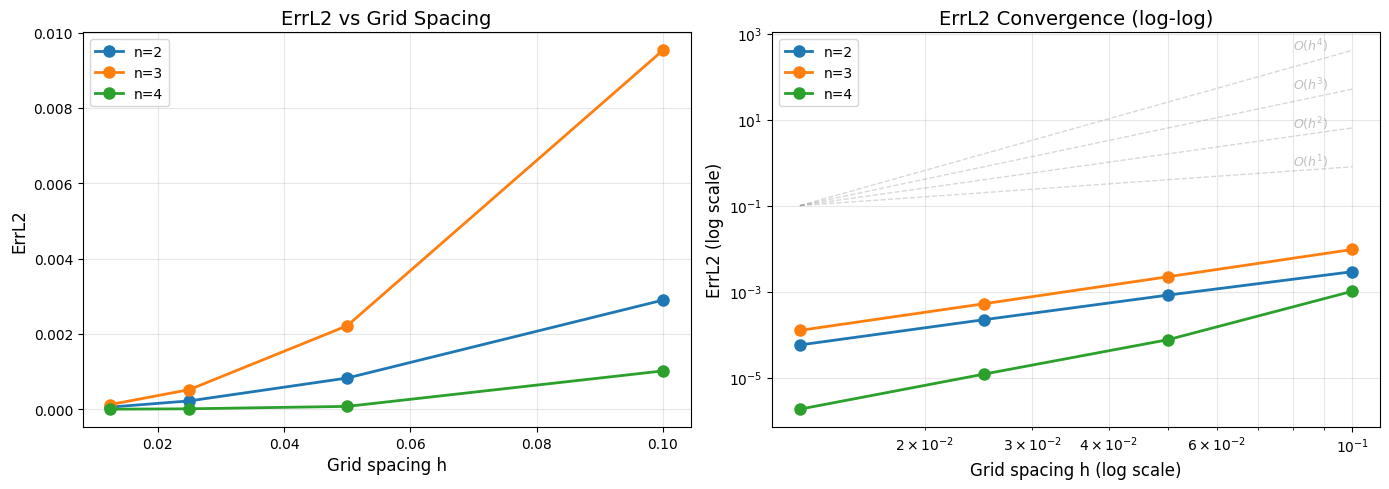


Convergence rates (log2 ratio):

Degree n = 2:
  H=10 → H=20: rate = 1.81
  H=20 → H=40: rate = 1.90
  H=40 → H=80: rate = 1.95

Degree n = 3:
  H=10 → H=20: rate = 2.10
  H=20 → H=40: rate = 2.09
  H=40 → H=80: rate = 2.06

Degree n = 4:
  H=10 → H=20: rate = 3.74
  H=20 → H=40: rate = 2.66
  H=40 → H=80: rate = 2.71


In [6]:
# Select error metric
error_metrics = ['ErrL2', 'ErrMax', 'MAE', 'L_inf', 'H1_semi', 'H1_error']
selected_metric = 'ErrL2'  # Change this to desired metric

print(f"Available metrics: {error_metrics}")
print(f"Plotting: {selected_metric}\n")

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Error vs h (linear scale)
for n in sorted(results.keys()):
    h = results[n]['h']
    error = results[n][selected_metric]
    
    # Filter out NaN values
    valid = ~np.isnan(error)
    if not np.any(valid):
        continue
    
    ax1.plot(h[valid], error[valid], 'o-', label=f'n={n}', linewidth=2, markersize=8)

ax1.set_xlabel('Grid spacing h', fontsize=12)
ax1.set_ylabel(f'{selected_metric}', fontsize=12)
ax1.set_title(f'{selected_metric} vs Grid Spacing', fontsize=14)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Log-log plot to show convergence order
for n in sorted(results.keys()):
    h = results[n]['h']
    error = results[n][selected_metric]
    
    # Filter out NaN and zero values
    valid = ~np.isnan(error) & (error > 0)
    if not np.any(valid):
        continue
    
    ax2.loglog(h[valid], error[valid], 'o-', label=f'n={n}', linewidth=2, markersize=8)

# Add reference lines for convergence orders
h_ref = np.array([results[list(results.keys())[0]]['h'].min(), 
                  results[list(results.keys())[0]]['h'].max()])
for order in [1, 2, 3, 4]:
    # Scale the reference line to fit in the plot
    y_ref = h_ref ** order
    y_ref = y_ref * 0.1 / y_ref[0]  # Normalize
    ax2.loglog(h_ref, y_ref, '--', alpha=0.3, color='gray', linewidth=1)
    ax2.text(h_ref[-1] * 0.8, y_ref[-1], f'$O(h^{order})$', 
             fontsize=9, alpha=0.5, color='gray')

ax2.set_xlabel('Grid spacing h (log scale)', fontsize=12)
ax2.set_ylabel(f'{selected_metric} (log scale)', fontsize=12)
ax2.set_title(f'{selected_metric} Convergence (log-log)', fontsize=14)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

# Print actual convergence rates
print("\nConvergence rates (log2 ratio):")
print("=" * 50)
for n in sorted(results.keys()):
    h = results[n]['h']
    error = results[n][selected_metric]
    valid = ~np.isnan(error) & (error > 0)
    
    if np.sum(valid) < 2:
        continue
    
    print(f"\nDegree n = {n}:")
    h_valid = h[valid]
    err_valid = error[valid]
    
    for i in range(1, len(h_valid)):
        rate = np.log2(err_valid[i-1] / err_valid[i])
        print(f"  H={1/h_valid[i-1]:.0f} → H={1/h_valid[i]:.0f}: rate = {rate:.2f}")

## Interactive Plot with Widget

In [7]:
def plot_convergence_interactive(metric='ErrL2', plot_type='both'):
    """Interactive plotting function."""
    if plot_type in ['linear', 'both']:
        fig_size = (14, 5) if plot_type == 'both' else (8, 5)
        ncols = 2 if plot_type == 'both' else 1
        fig, axes = plt.subplots(1, ncols, figsize=fig_size)
        if plot_type == 'linear':
            axes = [axes]
        else:
            axes = list(axes)
    else:
        fig, ax = plt.subplots(1, 1, figsize=(8, 5))
        axes = [ax]
    
    ax_idx = 0
    
    # Linear plot
    if plot_type in ['linear', 'both']:
        ax = axes[ax_idx]
        for n in sorted(results.keys()):
            h = results[n]['h']
            error = results[n][metric]
            valid = ~np.isnan(error)
            if np.any(valid):
                ax.plot(h[valid], error[valid], 'o-', label=f'n={n}', linewidth=2, markersize=8)
        
        ax.set_xlabel('Grid spacing h', fontsize=12)
        ax.set_ylabel(f'{metric}', fontsize=12)
        ax.set_title(f'{metric} vs Grid Spacing', fontsize=14)
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
        ax_idx += 1
    
    # Log-log plot
    if plot_type in ['loglog', 'both']:
        ax = axes[ax_idx]
        for n in sorted(results.keys()):
            h = results[n]['h']
            error = results[n][metric]
            valid = ~np.isnan(error) & (error > 0)
            if np.any(valid):
                ax.loglog(h[valid], error[valid], 'o-', label=f'n={n}', linewidth=2, markersize=8)
        
        # Reference lines
        h_ref = np.array([results[list(results.keys())[0]]['h'].min(), 
                          results[list(results.keys())[0]]['h'].max()])
        for order in [1, 2, 3, 4]:
            y_ref = h_ref ** order * 0.1 / h_ref[0] ** order
            ax.loglog(h_ref, y_ref, '--', alpha=0.3, color='gray', linewidth=1)
            ax.text(h_ref[-1] * 0.8, y_ref[-1], f'$O(h^{order})$', 
                   fontsize=9, alpha=0.5, color='gray')
        
        ax.set_xlabel('Grid spacing h (log scale)', fontsize=12)
        ax.set_ylabel(f'{metric} (log scale)', fontsize=12)
        ax.set_title(f'{metric} Convergence (log-log)', fontsize=14)
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3, which='both')
    
    plt.tight_layout()
    plt.show()

# Create interactive widget
metric_widget = widgets.Dropdown(
    options=error_metrics,
    value='ErrL2',
    description='Metric:',
    style={'description_width': 'initial'}
)

plot_type_widget = widgets.Dropdown(
    options=['both', 'linear', 'loglog'],
    value='both',
    description='Plot type:',
    style={'description_width': 'initial'}
)

interactive_plot = widgets.interactive(plot_convergence_interactive, 
                                       metric=metric_widget, 
                                       plot_type=plot_type_widget)
display(interactive_plot)

NameError: name 'widgets' is not defined

## Comparison Table

In [8]:
import pandas as pd

# Create comparison table
table_data = []
for key, stats in data['eval_stats'].items():
    if 'error' not in stats:
        table_data.append({
            'Degree': stats['n'],
            'H': stats['H'],
            'h': stats['h'],
            'ErrL2': f"{stats['ErrL2']:.4e}",
            'ErrMax': f"{stats['ErrMax']:.4e}",
            'MAE': f"{stats['MAE']:.4e}",
            'H1_semi': f"{stats['H1_semi']:.4e}" if stats['H1_semi'] is not None else 'N/A',
            'Dim': stats['dim_sys'],
            'Time (s)': f"{stats['rtimes']['total']:.3f}"
        })

df = pd.DataFrame(table_data)
df = df.sort_values(['Degree', 'H'])
print("\nConvergence Results Table:")
print("=" * 100)
display(df)


Convergence Results Table:


,Degree,H,h,ErrL2,ErrMax,MAE,H1_semi,Dim,Time (s)
0,2,10,0.1000,2.8986e-03,4.2354e-03,4.1522e-04,3.5477e-01,80,0.016
1,2,20,0.0500,8.2882e-04,1.4091e-03,1.1939e-04,2.3240e-01,316,0.019
2,2,40,0.0250,2.2176e-04,4.1386e-04,3.1657e-05,1.6669e-01,1264,0.069
3,2,80,0.0125,5.7352e-05,1.1349e-04,8.1857e-06,1.0141e-01,5024,1.069
4,3,10,0.1000,9.5326e-03,1.6974e-02,1.4769e-03,1.4244e-01,69,0.016
5,3,20,0.0500,2.2179e-03,4.9262e-03,3.1668e-04,1.8418e-01,305,0.147
6,3,40,0.0250,5.2089e-04,1.3351e-03,7.4134e-05,1.3253e-01,1245,0.104
7,3,80,0.0125,1.2493e-04,3.4830e-04,1.7856e-05,9.6462e-02,5013,1.107
8,4,10,0.1000,1.0178e-03,1.2186e-03,1.5722e-04,3.5527e-01,80,0.029
9,4,20,0.0500,7.6132e-05,2.3840e-04,7.3861e-06,2.3250e-01,316,0.126


## Error Comparison Across Degrees

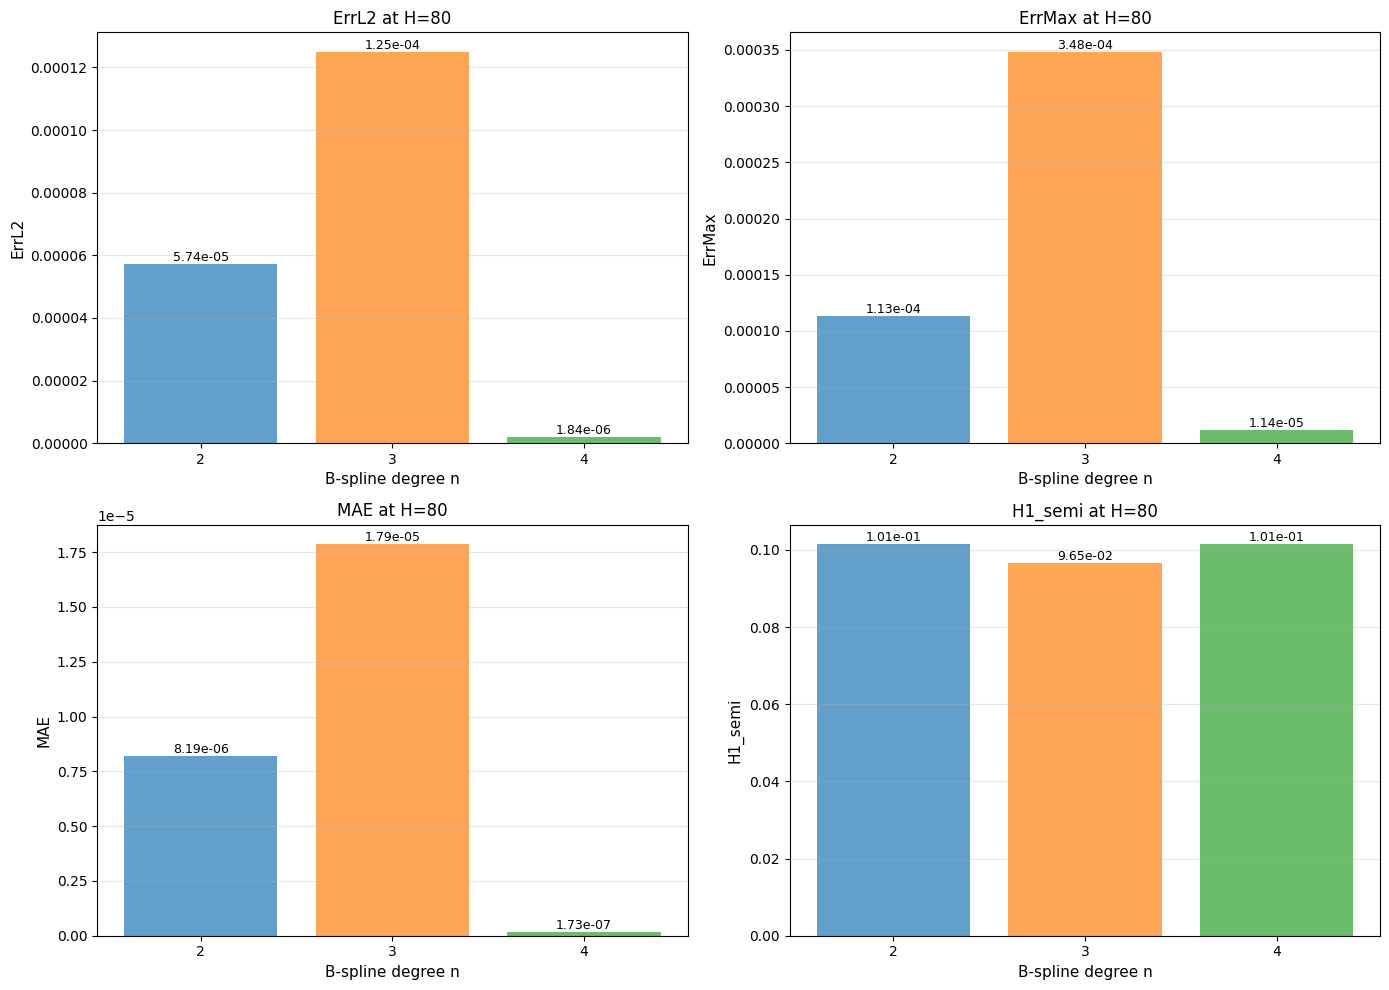


Error comparison at finest resolution H=80 (h=0.0125)


In [9]:
# Bar plot comparing errors at a fixed H
H_compare = data['H_values'][-1]  # Use finest resolution

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

metrics_to_plot = ['ErrL2', 'ErrMax', 'MAE', 'H1_semi']

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx]
    
    degrees = []
    errors = []
    
    for n in sorted(results.keys()):
        # Find index for H_compare
        h_idx = np.where(results[n]['H'] == H_compare)[0]
        if len(h_idx) > 0:
            error_val = results[n][metric][h_idx[0]]
            if not np.isnan(error_val):
                degrees.append(n)
                errors.append(error_val)
    
    if degrees:
        bars = ax.bar(degrees, errors, color=['C0', 'C1', 'C2', 'C3'][:len(degrees)], alpha=0.7)
        ax.set_xlabel('B-spline degree n', fontsize=11)
        ax.set_ylabel(metric, fontsize=11)
        ax.set_title(f'{metric} at H={H_compare}', fontsize=12)
        ax.set_xticks(degrees)
        ax.grid(True, alpha=0.3, axis='y')
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.2e}',
                   ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\nError comparison at finest resolution H={H_compare} (h={1/H_compare:.4f})")